In [2]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...


In [4]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [5]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

In [6]:
def distinct_words(corpus):
  all_words = []
  for i in range(len(corpus)):
    for j in range(len(corpus[i])):
      all_words.append(corpus[i][j])
  corpus_words = sorted(list(set(all_words)))
  num_corpus_words = len(corpus_words)
  return corpus_words, num_corpus_words

In [7]:
distinct_words_list, num_distinct_words = distinct_words(reuters_corpus)

In [8]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [9]:
def compute_co_occurrence_matrix(corpus, window_size=4):
  """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
  """
  words, num_words = distinct_words(corpus)
  M = None
  word2ind = {}
  word2ind = {word: i for i, word in enumerate(words)}
  M = np.zeros((num_words, num_words))
  for body in corpus:
    for current_index, word in enumerate(body):
      for window_index in range(-window_size, window_size + 1):
        neighbour_index = current_index + window_index
        if (neighbour_index < 0) or (neighbour_index >= len(body)) or (current_index == neighbour_index):
          continue
        co_occurrence_word = body[neighbour_index]
        (word_index, co_occurrence_index) = (word2ind[word], word2ind[co_occurrence_word])
        M[word_index, co_occurrence_index] += 1
  return M, word2ind

In [10]:
co_occurrence_matrix, word_index_dict = compute_co_occurrence_matrix(reuters_corpus, window_size=4)

In [11]:
co_occurrence_matrix

array([[78.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [13]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
def reduce_to_k_dim(M, k=2):
  """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
  """    
  n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
  M_reduced = None
  print("Running Truncated SVD over %i words..." % (M.shape[0]))
  svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
  svd.fit(M)
  M_reduced = svd.transform(M)
  print("Done.")
  return M_reduced

In [14]:
reduced_co_occurrence_matrix = reduce_to_k_dim(co_occurrence_matrix)

Running Truncated SVD over 8185 words...
Done.


In [15]:
reduced_co_occurrence_matrix.shape

(8185, 2)

In [16]:
reduced_co_occurrence_matrix

array([[ 7.32630060e+02, -1.16894192e+02],
       [ 1.26000427e+00, -1.61923588e-01],
       [ 2.80304332e-01,  6.47334603e-02],
       ...,
       [ 1.04145879e+00, -3.06320300e-01],
       [ 6.19972477e-01, -1.25537234e-01],
       [ 2.42230659e+00,  2.28089719e-01]])

In [17]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [18]:
import matplotlib.pyplot as plt
def plot_embeddings(M_reduced, word2ind, words):
  """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
  """
  for i, word in enumerate(words):
    word_index = word2ind[word]
    plt.scatter(M_reduced[word_index][0], M_reduced[word_index][1], marker='x', color='red')
    plt.text(M_reduced[word_index][0]+0.01, M_reduced[word_index][1]+0.01, words[i], fontsize=9)
  plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


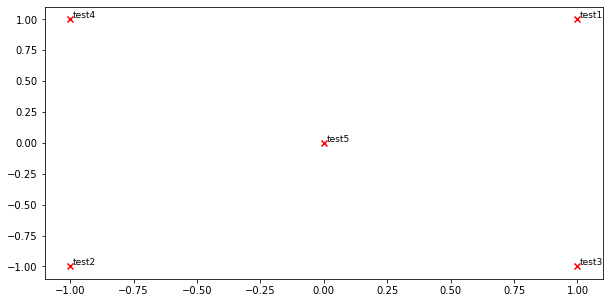

--------------------------------------------------------------------------------


In [19]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

Running Truncated SVD over 8185 words...
Done.


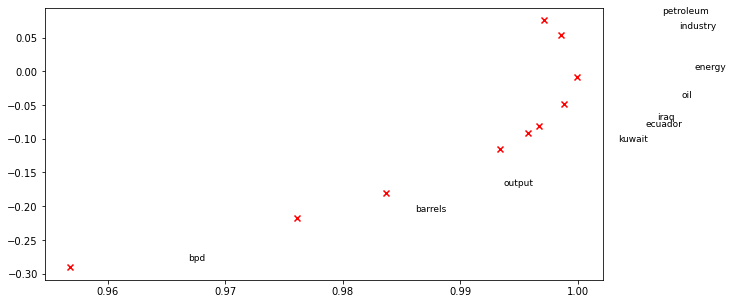

In [20]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

Kuwait, Ecuador and Iraq are clustered together.
Petroleum and industry are clustered together.
Oil and energy are clustered together.
Bpd, barrels and output are not clustered together and not clustered with rest of the words.

In [21]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [22]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


In [23]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [24]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


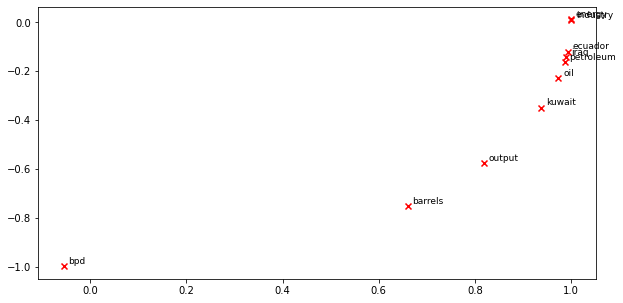

In [25]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

Both plots are simliar. However, bpd is mre extremely far. Equador, Iraq and petroleum are clustered together instead of Ecuador, Iraq and Kuwait. Oil and energy are not clustered together unlike earlier. Energy and industry are clustered together unlike earlier. Different way of word vector generation is the main reason for it.

In [34]:
wv_from_bin.most_similar("row")

[('rows', 0.5728933811187744),
 ('straight', 0.5502231121063232),
 ('over', 0.5451182723045349),
 ('six', 0.5256698131561279),
 ('eight', 0.5122817754745483),
 ('fifth', 0.5115676522254944),
 ('four', 0.5093084573745728),
 ('fourth', 0.5038901567459106),
 ('five', 0.5016255378723145),
 ('three', 0.49834975600242615)]

Several words like bank (financial and river bank) did not yield result. The word "row" yielded result with meanings of rowing over and row numbers. This is because machine is understanding only one meaning very well. It may be due to limited data which corresponds mainly to single use of word.

In [41]:
w1 = "rich"
w2 = "poor"
w3 = "affluent"
print(wv_from_bin.distance(w1, w2))
print(wv_from_bin.distance(w1, w3))

0.5232120156288147
0.5737791061401367


Rich is closer to poor than affluent since there is less cosine distance. This might be due to the way these words are understood by machine. The words rich and poor are generally used in similar contexts though with opposite meanings. The context in which these are used may seem to influence cosine distance better.

In [42]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]


Woman may lie farther to king than man due to dissimilairty.

In [45]:
pprint.pprint(wv_from_bin.most_similar(positive=['fire', 'cloud'], negative=['water']))

[('fires', 0.5052489638328552),
 ('clouds', 0.4968753457069397),
 ('shadow', 0.47313570976257324),
 ('blaze', 0.4647306799888611),
 ('smoke', 0.4644941985607147),
 ('firing', 0.43263113498687744),
 ('erupted', 0.4250633120536804),
 ('explosions', 0.42309272289276123),
 ('explosion', 0.42195191979408264),
 ('fired', 0.4206998944282532)]


Cloud is explosion of water. Explosion is explosion of fire.

In [46]:
pprint.pprint(wv_from_bin.most_similar(positive=['gun', 'doll'], negative=['girl']))

[('guns', 0.495147168636322),
 ('handgun', 0.47256872057914734),
 ('toy', 0.46542131900787354),
 ('submachine', 0.45236048102378845),
 ('firearms', 0.42657947540283203),
 ('firearm', 0.4246947765350342),
 ('replica', 0.4197266101837158),
 ('gatling', 0.4175325334072113),
 ('sub-machine', 0.4126133322715759),
 ('rifle', 0.40851449966430664)]


Correct analogy would have been boy according to gender stereotyping. Boy is to gun like girl is to doll. But the machine is unable to understand this context. However, machine is trying to create words that represent toys and guns like replica.

In [47]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]


Teacher, nurse, homemaker etc are showing bias wrt women and laborer, mechanic, unemployed, factory etc are showing bias wrt men.

In [55]:
wv_from_bin.most_similar("star")

[('stars', 0.8256307244300842),
 ('superstar', 0.6607545614242554),
 ('actor', 0.5768247842788696),
 ('movie', 0.5601697564125061),
 ('player', 0.5533201098442078),
 ('hollywood', 0.5391762256622314),
 ('veteran', 0.5315371751785278),
 ('starring', 0.5275611877441406),
 ('starred', 0.5274866819381714),
 ('actress', 0.5270617604255676)]

Here, actor is more similar compared to actress showing bias.

Bias gets into vectors through data based on bias writings. Bias writings occur due to many reasons like socoeconomic conditions, culture, genuine mistakes or onpurpose biased writings. 
Experiment:
1) Identifying biases in society and finding the bias terms, bias related surrounding terms and bias contexts.
2) Finding these terms, related terms and contexts in the source documents.